# ***Project Title:*** Water Treatment Plant Data Analysis

## **Introduction**




## **About Dataset**

The data set includes a variety of parameters such as:
*   pH: This is a measure of the acidity or alkalinity of the water, with a range from 0 to 14.

*   Chlorine: Chlorine is a disinfectant used to kill bacteria and other microorganisms in water.

*   Turbidity: This measures the amount of suspended particles in the water, which can be caused by clay, silt, algae, or other organic matter.

*   Total Dissolved Solids: This measures the amount of dissolved solids such as salts and minerals present in the water.

*   Hardness: This measures how much calcium and magnesium are present in the water.

*   Alkalinity: This measures how much alkaline material such as bicarbonates and carbonates are present in the water.

*   Aluminum: Aluminium in water is a form of dissolved aluminum, which is the result of aluminum ions being released into the water from natural sources such as rocks and soil.

*   Chemical Dosages (Chlorine, Alum, Lime(Pre), Lime(Post)): This feature is a measure of the number of chemicals used to treat water.



### ***Importing the necessary libraries***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
0!pip install prophet pyspark pandas
import os
import sys
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from functools import reduce
from prophet import Prophet
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType,TimestampType
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql import dataframe
from sklearn.impute import KNNImputer
from pyspark.sql import *
from pyspark.conf import SparkConf
from pyspark import SparkContext
from pyspark.sql.functions import mean, when, col, sum, split, udf, skewness, lit
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.types import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 18.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=befbd40f835cb82342d752b8b7b4e9c5f7062fd1e23dbce2696b6071e1d66ba9
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
def init_spark():
    # Create a new SparkSession object with a specific app name and configuration options
    spark = SparkSession.builder.appName("BigDataProject") \
                        .config("spark.some.config.option", "some-value") \
                        .config("spark.driver.memory", "10g") \
                        .getOrCreate()
    
    # Return the SparkSession object
    return spark


In [ ]:
spark=init_spark()

# ***Data Loading and Preprocessing***

### **Helper Functions**

In [ ]:
def readData(path):
    # Read the CSV file into a Spark dataframe
    df_full = spark.read.csv(path, header=True, inferSchema=True)

    # Convert all string columns to double type
    data_types = df_full.dtypes
    for col_name, col_type in data_types:
        if col_type == "string":
            df_full = df_full.withColumn(col_name, df_full[col_name].cast("double"))
    return df_full


def dropCols(lis, dataset):
    # Drop the specified columns from the given dataset
    for i in lis:
        dataset = dataset.drop(i)
    return dataset


def column_add(a,b):
     return  a.__add__(b)


def deleteAllZeroValuedRows(dataset):
    # Replace null values with zero
    dataset = dataset.fillna(0)
    # Add a temporary column total_col which is the sum of all columns in the dataset
    dataset = dataset.withColumn('total_col', reduce(column_add, (dataset[col] for col in dataset.columns)))
    # Delete rows where total_col is zero
    dataset = dataset.filter(dataset["total_col"] > 0.0)
    # Drop the temporary column total_col
    dataset = dataset.drop("total_col")
    # Replace all zero values with null values
    dataset = dataset.select([when(col(c) == 0.0, lit(None)).otherwise(col(c)).alias(c) for c in dataset.columns])

    return dataset

def replaceNullValAppropriately(dataset):
    # Check each column for skewness and put it in the appropriate bucket to later deal with null values.
    # If a column is skewed, replace null values with median otherwise replace them with mean
    dataset = dataset.replace(0,None)
    skewed_cols=[]
    non_skewed_col=[]
    for f in dataset.columns:
      if(abs(dataset.select(skewness(f)).collect()[0][0])>1.0):
          skewed_cols.append(f)
      else:
          non_skewed_col.append(f)


    #replacing it with median
    imputer = Imputer(inputCols=skewed_cols, outputCols=skewed_cols)
    imputer.setStrategy("median")
    dataset=imputer.fit(dataset).transform(dataset)

    #replacing it with mean
    imputer2 = Imputer(inputCols=non_skewed_col, outputCols=non_skewed_col)
    imputer2.setStrategy("mean")
    dataset=imputer2.fit(dataset).transform(dataset)

    return dataset

def readyDataForModelling(dataset, independent_col_name, dependent_col_name, list_rows_dependent_variable):
    # Skip the last three dependent variables
    featureassembler= VectorAssembler(inputCols=list_rows_dependent_variable,outputCol=independent_col_name,handleInvalid="skip")
    output=featureassembler.transform(dataset)
    output = output.drop(independent_col_name)
    return output,featureassembler

# Define a function to compute the standard deviation of a column in a PySpark DataFrame
def findSTD(col_name, preds):
    # Compute the average of the specified column
    total = preds.select(col_name).rdd.map(lambda x: x[0]).reduce(lambda x, y: x + y)
    avg = total / (preds.count())
    
    # Compute the variance of the specified column
    res = preds.select(col_name).rdd.map(lambda x: (x[0] - avg) ** 2).reduce(lambda x, y: x + y)
    res = res / preds.count()
    
    # Compute and return the standard deviation of the specified column
    return math.sqrt(res)


# ***Data Exploration***

In [ ]:
def check_missing_value(dataset):
    # Print the schema of the dataset
    dataset.printSchema()
    
    # Show the summary statistics of the dataset
    dataset.describe().show()
    
    # Show the number of missing values for each column in the dataset
    dataset.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in dataset.columns)).show()


def calculate_spearman_corr(dataset, target_variable):
    # This function calculates the spearman correlation between each variable and the target variable.
    df_corr = pd.DataFrame({'features': dataset.columns})
    df_corr['spearman'] = [dataset.stat.corr(c, target_variable) for c in dataset.columns]
    df_corr = df_corr.sort_values('spearman')
    return df_corr


def plot_spearman_corr(df_corr):
    # This function plots the spearman correlation for each variable.
    plt.figure(figsize=(6, 0.25 * len(df_corr)))
    sns.barplot(data=df_corr, y='features', x='spearman', orient='h')
    plt.show()


def spearman_corr(dataset):
    # This function analyzes the spearman correlation between each variable and three different target variables.
    target_variables = ['Chemical_Dosages_Chlorine', 'Chemical_Dosages_Alum', 'Chemical_Dosages_Limestone']
    for target_variable in target_variables:
        df_corr = calculate_spearman_corr(dataset, target_variable)
        plot_spearman_corr(df_corr)


def pearson_corr_heatmap(dataset):
    """
    This function is used to analyze the pearson correlation between each variable including the target variable.
    Generally to reduce confounding, only variables uncorrelated with each other should be added to regression models.
    """

    # Assemble the input features
    assembler = VectorAssembler(inputCols=dataset.columns, outputCol='features', handleInvalid='keep')
    assembled = assembler.transform(dataset)
    
    # Compute the correlation matrix
    pearson_corr = Correlation.corr(assembled, 'features')
    
    # Convert the correlation matrix to a DataFrame
    corr_list = pearson_corr.head()[0].toArray().tolist()
    pearson_corr_df = spark.createDataFrame(corr_list)
    
    # Rename the columns of the DataFrame to match the input features
    mapping = dict(zip(pearson_corr_df.columns, dataset.columns))
    pearson_corr_df = pearson_corr_df.select([col(c).alias(mapping.get(c, c)) for c in pearson_corr_df.columns])

    # Plot the correlation matrix as a heatmap
    plt.figure(figsize=(50, 50))
    sns.heatmap(pearson_corr_df.toPandas(), annot=True, yticklabels=pearson_corr_df.columns)
    plt.savefig('pearson_corr_heatmap.png', bbox_inches='tight')
    plt.show()




In [ ]:
data_visualize = readData('/content/drive/MyDrive/cleaned_data.csv')
l = ["Date","Flows_from_plant_Bishop's","Flows_from_plant_Botwood","Flows_from_plant_GFW"]
data_visualize= dropCols(l,data_visualize)
data_visualize = deleteAllZeroValuedRows(data_visualize)
data_visualize = replaceNullValAppropriately(data_visualize)

**Descriptive statistics of each column and Checking missing values**

In [ ]:
check_missing_value(data_visualize)

root
 |-- pH_Raw: double (nullable = true)
 |-- pH_PTC: double (nullable = true)
 |-- pH_PTC_(OL): double (nullable = true)
 |-- pH_SWC: double (nullable = true)
 |-- pH_Filter: double (nullable = true)
 |-- pH_Finish_(OL): double (nullable = true)
 |-- pH_Finish: double (nullable = true)
 |-- Chlorine_Free: double (nullable = true)
 |-- Chlorine_Total: double (nullable = true)
 |-- Chlorine_Sample: double (nullable = true)
 |-- Chlorine_Analyzer: double (nullable = true)
 |-- Colour_Raw_A: double (nullable = true)
 |-- Colour_Raw_T: double (nullable = true)
 |-- Colour_SWC_A: double (nullable = true)
 |-- Colour_Filter_A: double (nullable = true)
 |-- Colour_Finish_A: double (nullable = true)
 |-- Colour_Finish_T: double (nullable = true)
 |-- Turbidity_Raw: double (nullable = true)
 |-- Turbidity_Raw_(OL): double (nullable = true)
 |-- Turbidity_SWC: double (nullable = true)
 |-- Turbidity_Filter: double (nullable = true)
 |-- Turbidity_Finish: double (nullable = true)
 |-- Turbidity

**Spearman Correlation**

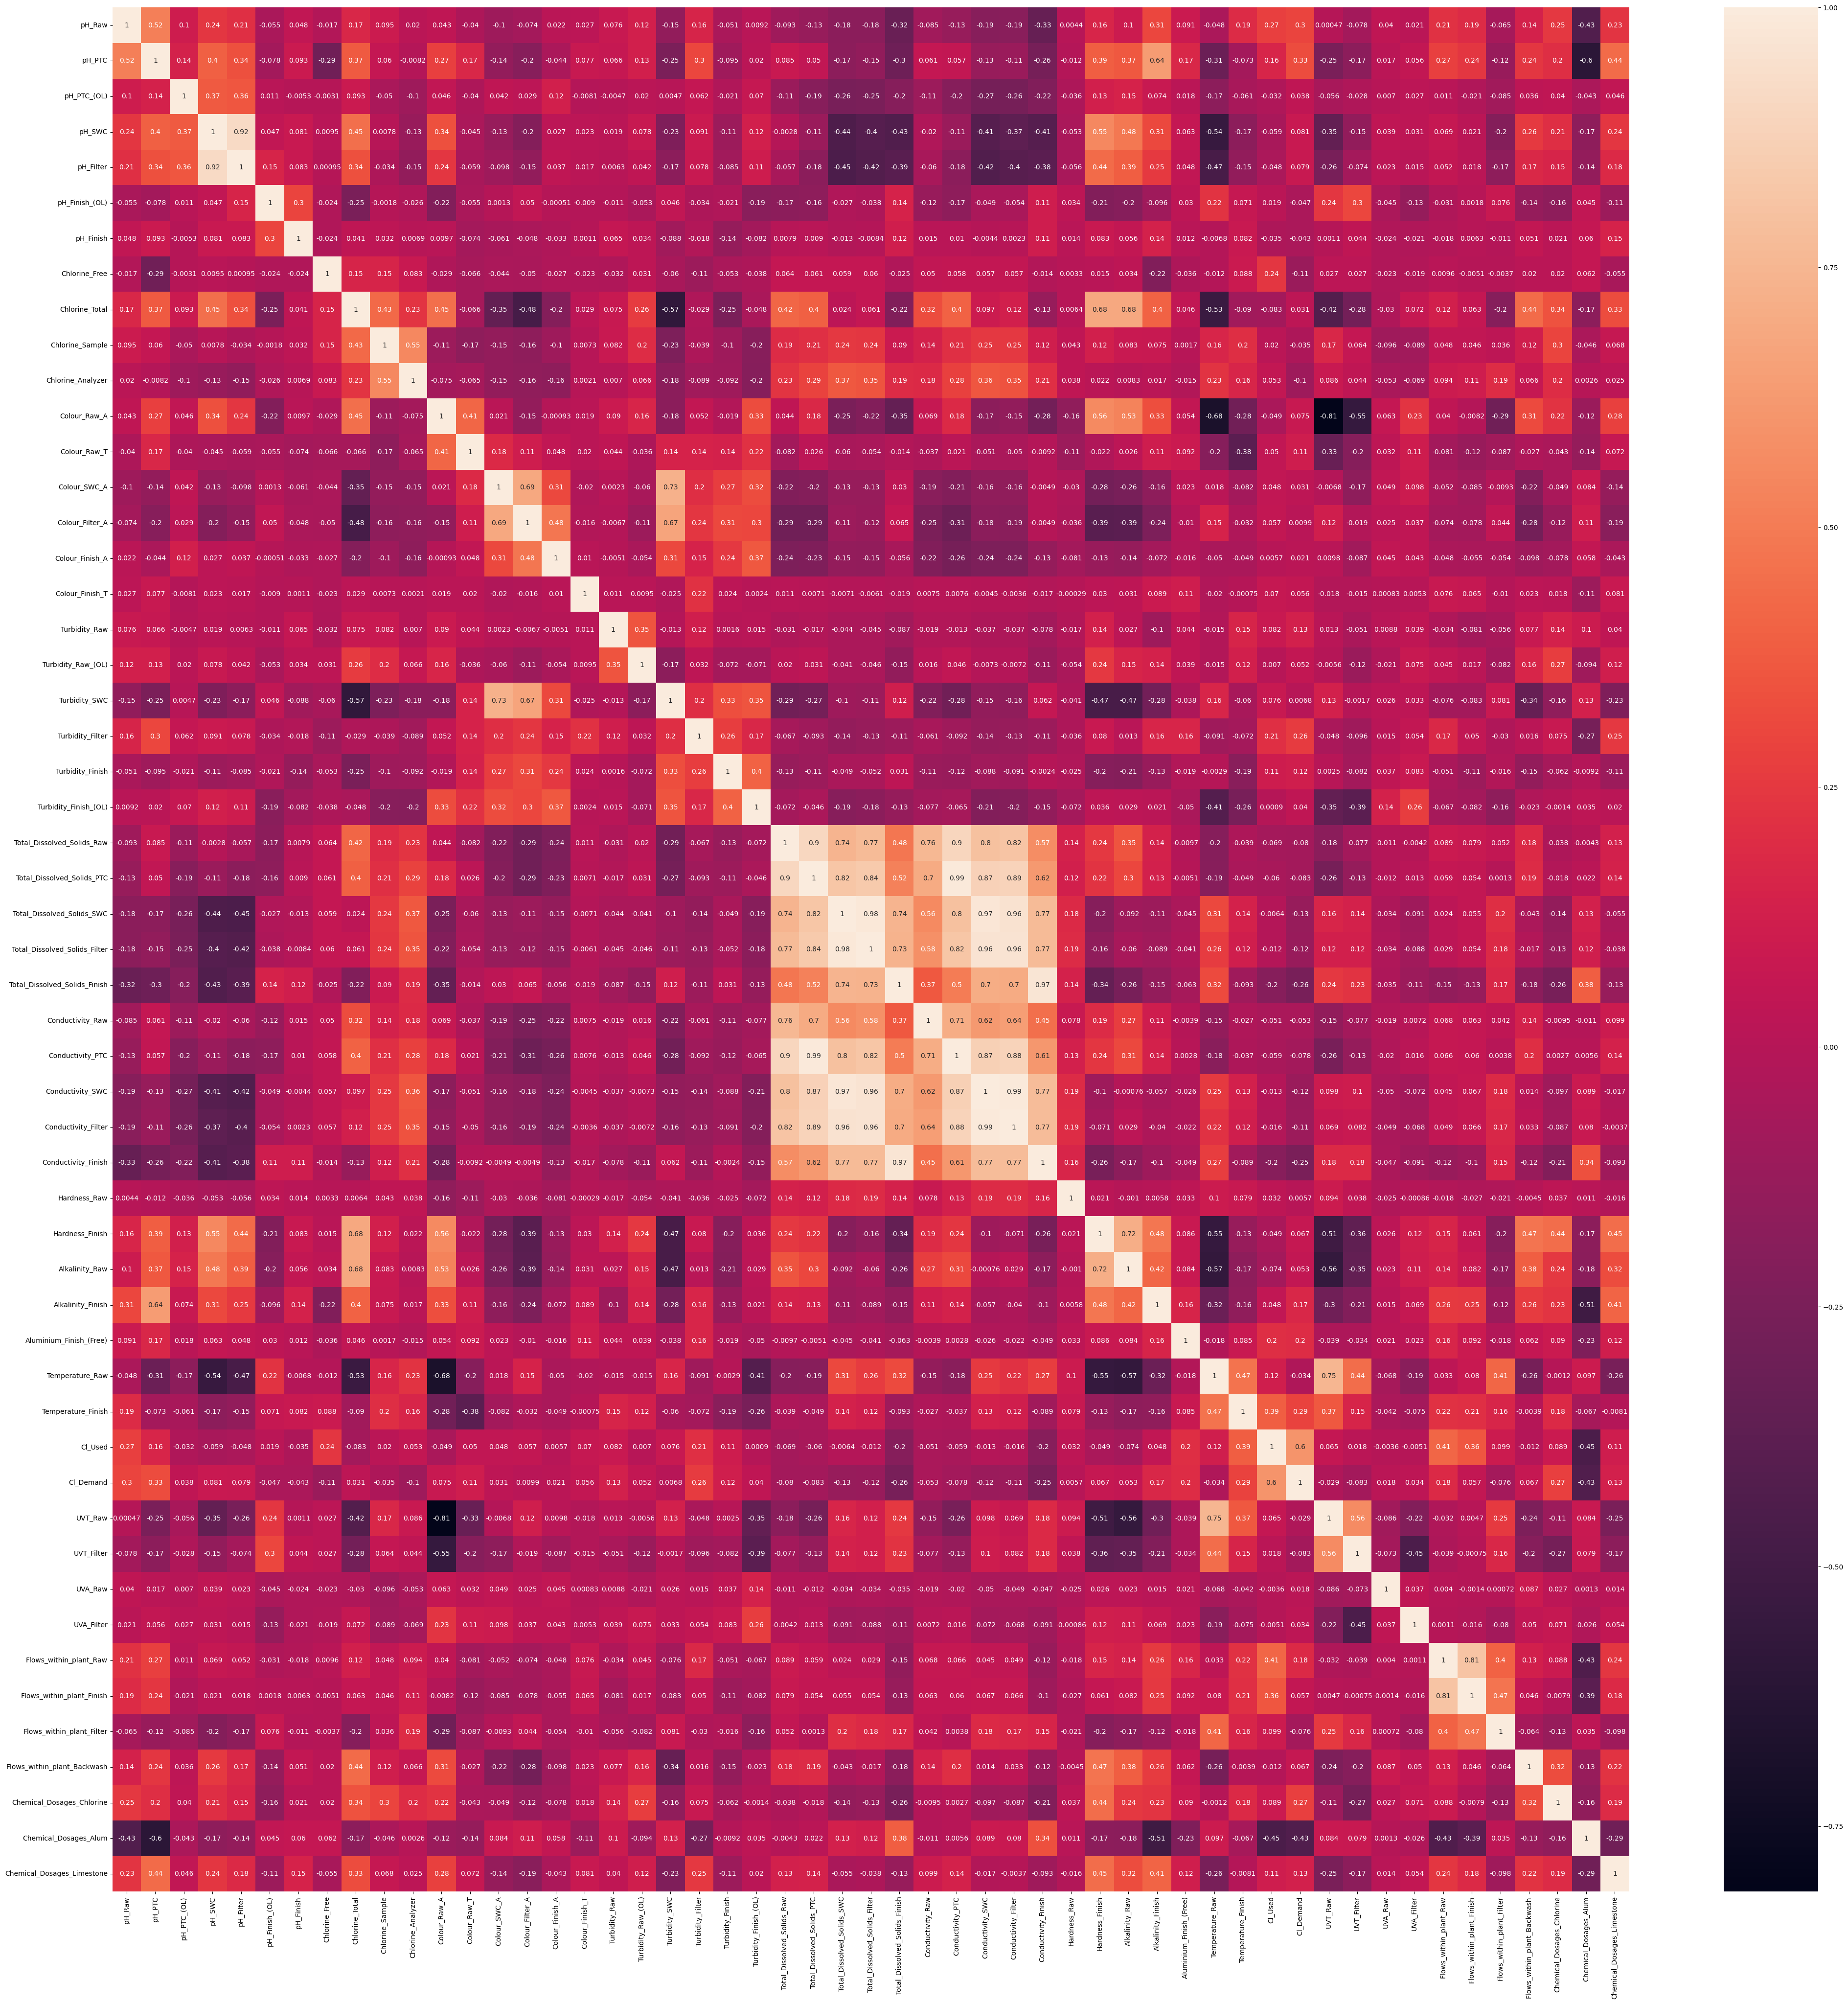

In [ ]:
pearson_corr_heatmap(data_visualize)

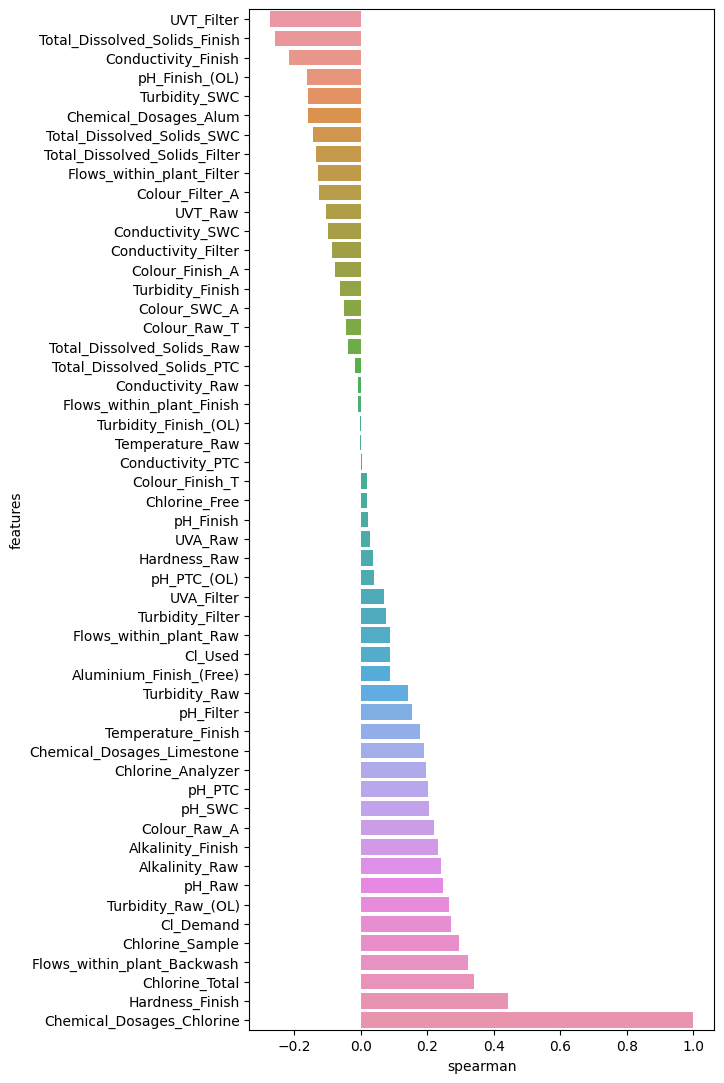

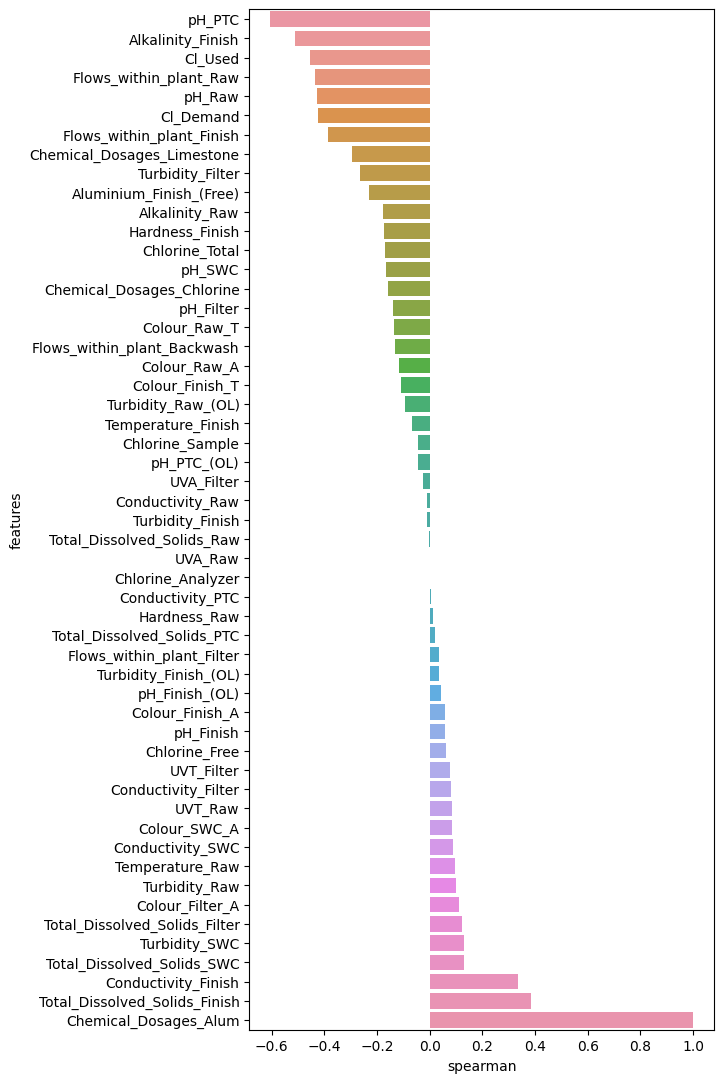

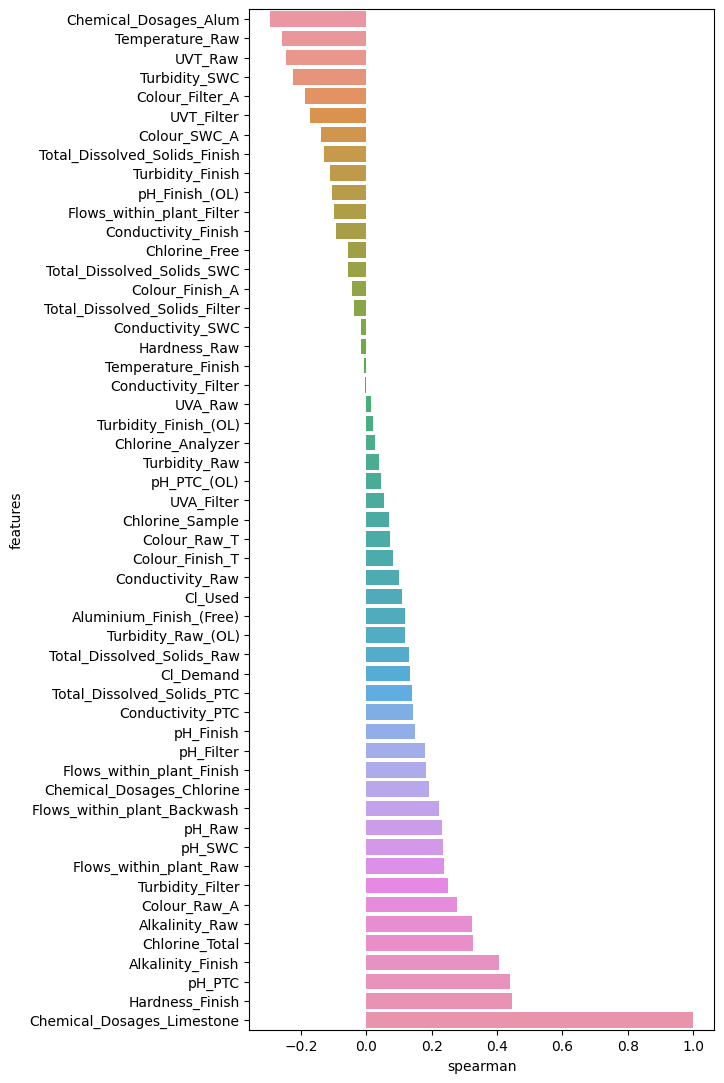

In [ ]:
spearman_corr(data_visualize)

**Data loading, preprocessing, splitting and preparation for modeling.**

In [ ]:
# Define a list of column names to select from the dataset
lis = ['pH_Raw','Total_Dissolved_Solids_Raw','Conductivity_Raw','Hardness_Raw','Alkalinity_Raw','Cl_Used','Cl_Demand','pH_PTC','Chlorine_Free' \
       ,'Chlorine_Sample','Turbidity_Filter','Turbidity_Raw','Chemical_Dosages_Alum']

# Load the data from an Excel file and preprocess it
full_data = readData('/content/drive/MyDrive/cleaned_data.csv') # load the data from an Excel file
full_data = full_data.select(lis)
full_data = deleteAllZeroValuedRows(full_data) # delete rows with all zero values

# Split the preprocessed data into training and testing sets
train_df_wout_dependentfeature, test_df_wout_dependentfeature = full_data.randomSplit([0.8, 0.2], seed=123)

# Replace null values in the training and testing datasets with appropriate values
train_df_wout_dependentfeature = replaceNullValAppropriately(train_df_wout_dependentfeature)
test_df_wout_dependentfeature = replaceNullValAppropriately(test_df_wout_dependentfeature)

# Prepare the data for modelling by selecting independent and dependent features
train_df_wout_dependentfeature,featureassembler = readyDataForModelling(train_df_wout_dependentfeature, "Independent_feature", "Chemical_Dosages_Alum", train_df_wout_dependentfeature.columns[:-1])
test_df_wout_dependentfeature,featureassembler2 = readyDataForModelling(test_df_wout_dependentfeature, "Independent_feature", "Chemical_Dosages_Alum", test_df_wout_dependentfeature.columns[:-1])


### ***Random Forest Regression model***

In [ ]:
from pyspark.ml.regression import LinearRegression,RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import rand
from pyspark.ml import Pipeline


rf= RandomForestRegressor(featuresCol="Independent_feature", labelCol="Chemical_Dosages_Alum")

# Define the parameter grid to search over
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30,40]) \
    .addGrid(rf.maxDepth, [3, 5,7, 10]) \
    .build()

rf_pipeline = Pipeline(stages=[featureassembler,rf])
# Define the evaluator for measuring the performance of the model
rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Chemical_Dosages_Alum", metricName="rmse")
# Define the cross-validator for performing k-fold cross-validation
rf_cv = CrossValidator(estimator=rf_pipeline, estimatorParamMaps=rf_paramGrid, evaluator=rf_evaluator, numFolds=5)

# Fit the cross-validator to the training data
rf_cvModel = rf_cv.fit(train_df_wout_dependentfeature)
# Evaluate the model on the test data 
rf_predictions = rf_cvModel.bestModel.transform(test_df_wout_dependentfeature)
rf_rmse = rf_evaluator.evaluate(rf_predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rf_rmse)
rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='Chemical_Dosages_Alum', metricName="mae")
print(f"MAE {rf_evaluator.evaluate(rf_predictions)}")

rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='Chemical_Dosages_Alum', metricName="r2")
print(f"R2 {rf_evaluator.evaluate(rf_predictions)}")
print(f'Actual {findSTD("Chemical_Dosages_Alum",rf_predictions)}')
print(f'Predicted: {findSTD("prediction",rf_predictions)}')


Root Mean Squared Error (RMSE) on test data = 3.66909
MAE 2.185633030030193
R2 0.8094515372738541
Actual 8.405345691583713
Predicted: 6.870180056276173


### ***Decision Tree Regression model***

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import rand
from pyspark.ml import Pipeline

dt = DecisionTreeRegressor(featuresCol="Independent_feature", labelCol="Chemical_Dosages_Alum")

dt_paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 7, 11]) \
    .build()

pipeline_dt = Pipeline(stages=[featureassembler, dt])
# Define the evaluator for measuring the performance of the model
dt_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Chemical_Dosages_Alum", metricName="rmse")

# Define the cross-validator for performing k-fold cross-validation
dt_cv = CrossValidator(estimator=pipeline_dt, estimatorParamMaps=dt_paramGrid, evaluator=dt_evaluator, numFolds=4)

# Fit the cross-validator to the training data
dt_cvModel = dt_cv.fit(train_df_wout_dependentfeature)

# Evaluate the model on the test data
dt_predictions = dt_cvModel.bestModel.transform(test_df_wout_dependentfeature)
dt_rmse = dt_evaluator.evaluate(dt_predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % dt_rmse)
dt_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='Chemical_Dosages_Alum', metricName="mae")
print(f"MAE {dt_evaluator.evaluate(dt_predictions)}")

dt_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='Chemical_Dosages_Alum', metricName="r2")
print(f"R2 {dt_evaluator.evaluate(dt_predictions)}")
print(f'Actual {findSTD("Chemical_Dosages_Alum",dt_predictions)}')
print(f'Predicted: {findSTD("prediction",dt_predictions)}')

Root Mean Squared Error (RMSE) on test data = 4.36482
MAE 2.365009604748788
R2 0.7303369593023006
Actual 8.405345691583713
Predicted: 7.49107339143413


### ***Linear regression model***

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import rand

# Define the linear regression model
lr = LinearRegression(featuresCol="Independent_feature", labelCol="Chemical_Dosages_Alum")

# Define the parameter grid for tuning the model
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1,1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5,0.1]) \
    .build()

lr_pipeline = Pipeline(stages=[featureassembler,lr])
# Define the evaluator for measuring the performance of the model
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Chemical_Dosages_Alum", metricName="rmse")
# Define the cross-validator for performing k-fold cross-validation
lr_cv = CrossValidator(estimator=lr_pipeline, estimatorParamMaps=lr_paramGrid, evaluator=lr_evaluator, numFolds=5)

# Fit the cross-validator to the training data
lr_cvModel = lr_cv.fit(train_df_wout_dependentfeature)

# Evaluate the model on the test data
lr_predictions = lr_cvModel.transform(test_df_wout_dependentfeature)
lr_rmse = lr_evaluator.evaluate(lr_predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % lr_rmse)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='Chemical_Dosages_Alum', metricName="mae")
print(f"MAE {lr_evaluator.evaluate(lr_predictions)}")

lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='Chemical_Dosages_Alum', metricName="r2")
print(f"R2 {lr_evaluator.evaluate(lr_predictions)}")

print(f'Actual {findSTD("Chemical_Dosages_Alum",lr_predictions)}')
print(f'Predicted: {findSTD("prediction",lr_predictions)}')


Root Mean Squared Error (RMSE) on test data = 5.72332
MAE 4.11353573516846
R2 0.5363555768046749
Actual 8.405345691583713
Predicted: 5.909289886647139


## **Question 2 - Time Series Analysis Prediction**




In [ ]:
# Read in the cleaned data CSV file
data = pd.read_csv('/content/cleaned_data.csv')

# Get the column names of all columns except the first
cols = data.columns[1:]

# Add an 'id' column to the data
data.insert(0,'id',range(1,len(data)+1))

# Get the first two columns of the data (date information)
date=data.iloc[:,:2]

# Drop the 'Date' column from the data
data=data.drop('Date',axis=1)

# Convert the data type of all columns except the first
data[cols] = data[cols].astype(float)

# Initialize the KNNImputer with the number of neighbors to use
imputer = KNNImputer(n_neighbors=3)

data = data.replace(0, np.nan)
# # Replace missing values with KNN imputation
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
data=pd.merge(data,date,on='id')

#changing index of date column to first column
colms = data.columns[1:-1]
colms = colms.insert(0,'Date')
data = data[colms]

# Drop all rows with missing values in the 'Date' column
data = data.dropna(subset=['Date'])

# Select a subset of columns to keep
col_names= ['Date','pH_Raw','Chlorine_Free','Total_Dissolved_Solids_Raw','Hardness_Raw','Alkalinity_Raw','UVT_Raw']
data = data[col_names]

##***Helper Function***

In [ ]:
def changeData(pdf):
  # Melt the DataFrame to create a new column for various category names
  melted_df = pd.melt(pdf, id_vars=['Date'], var_name='categories')

  # Create a new column for the corresponding category values
  melted_df['value'] = melted_df['value']

  # assign numeric values to the categorical values
  categories_codes= {'pH_Raw':1,'Chlorine_Free':2,'Total_Dissolved_Solids_Raw':3,'Hardness_Raw':4,'Alkalinity_Raw':5,'UVT_Raw':6}

  # We map the numerical codes to the corresponding categorical values using the categories_codes dictionary
  melted_df['category_code'] = melted_df['categories'].map(categories_codes)

  return melted_df


In [ ]:
# Store data for Later Use
final_df = data
# Call the changeData function on the 'data' DataFrame and store the result in 'reshaped_data'
reshaped_data = changeData(data)
reshaped_data.to_csv('reshaped_data.csv',index=False)


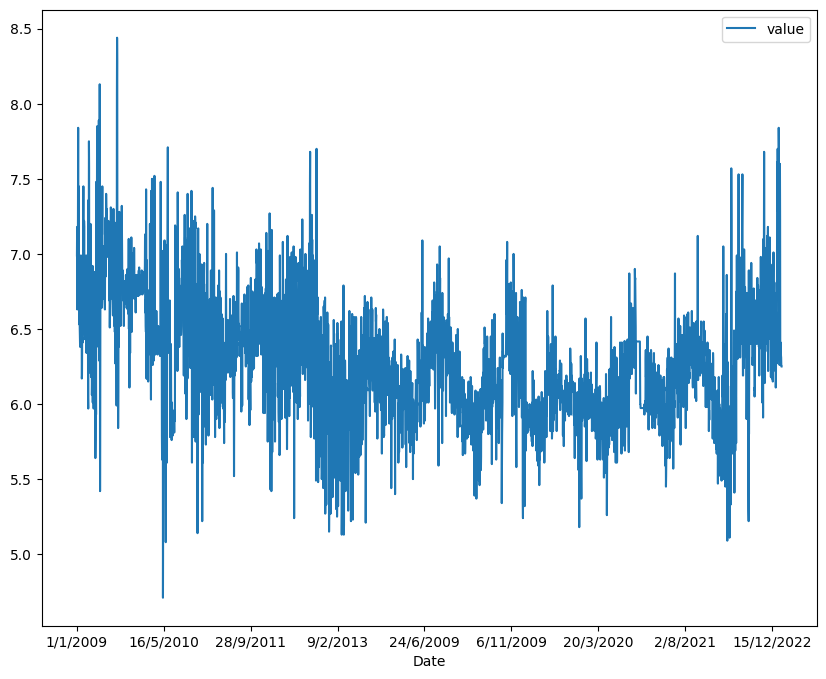

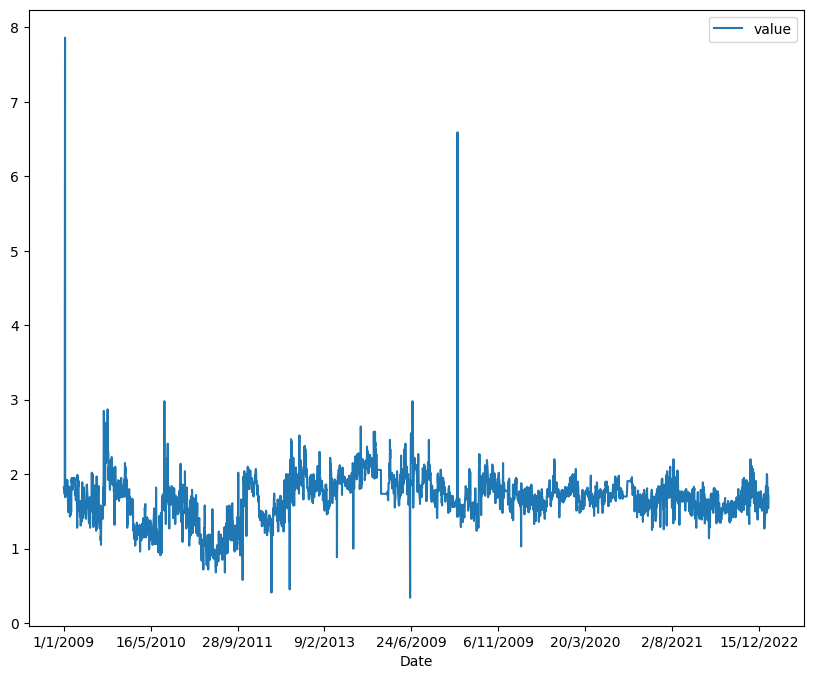

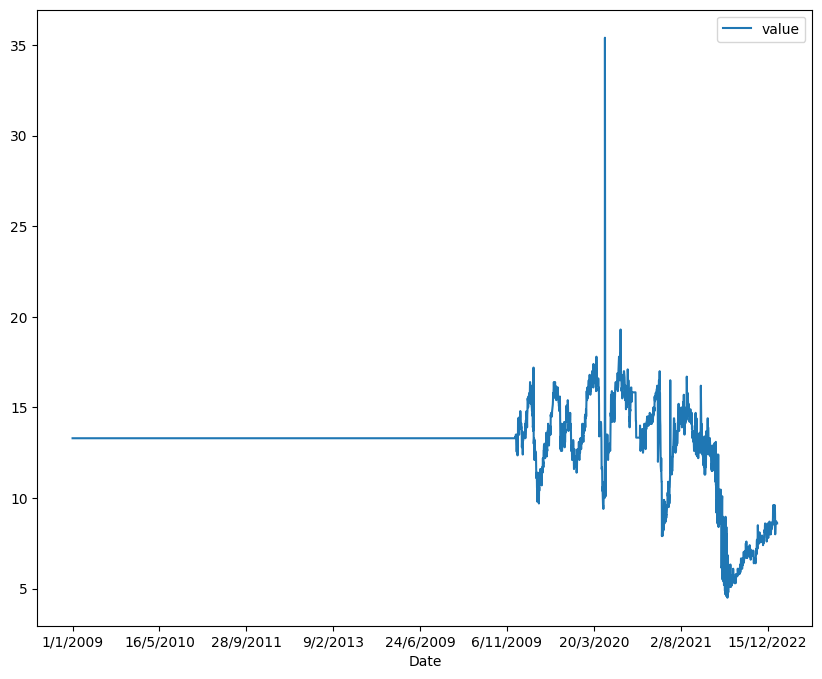

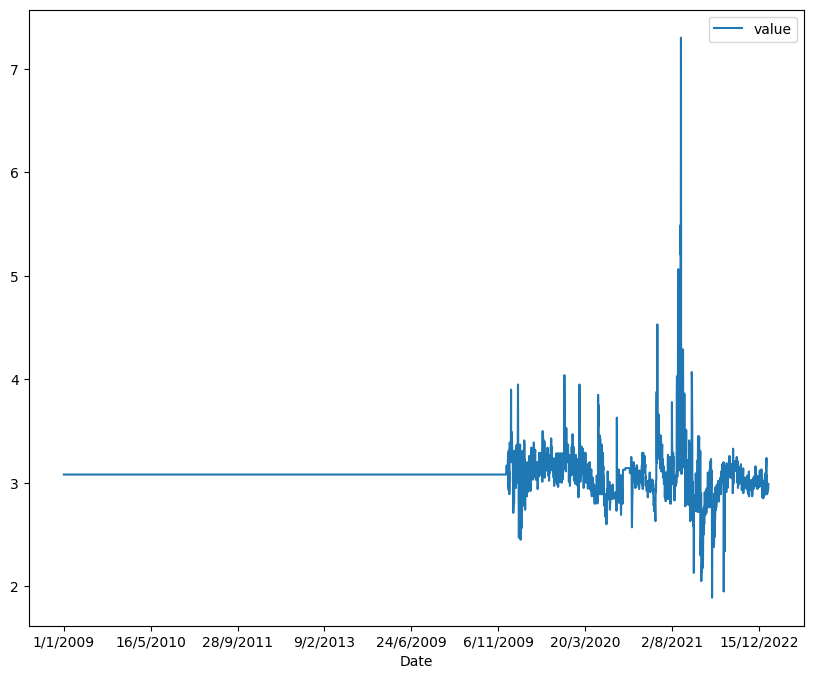

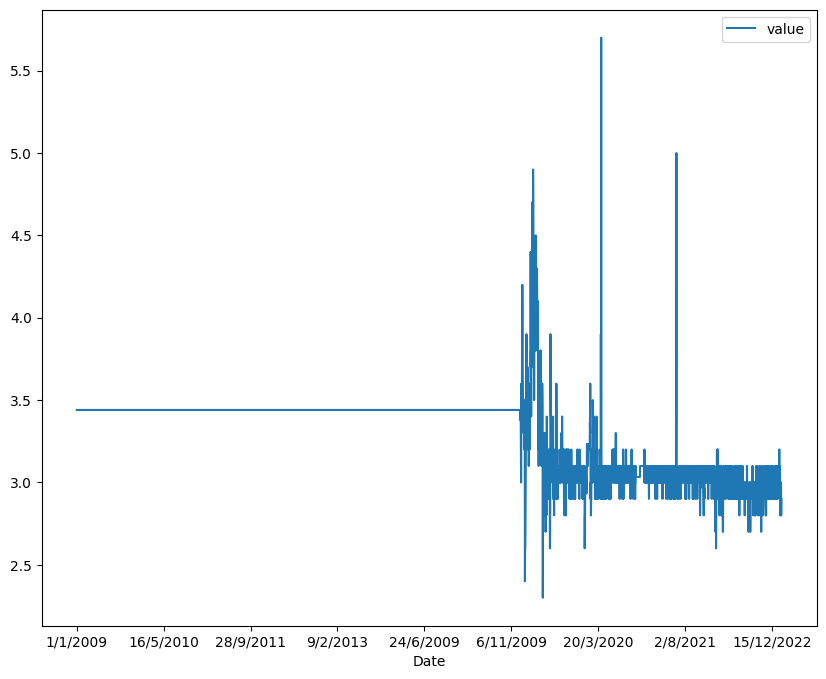

In [ ]:
for i in range(1,6):
  # Create a string that represents the condition we want to filter on
  st="category_code=="+str(i)

  # Set the 'Date' column as the index of the DataFrame
  item_df = reshaped_data.set_index('Date')

  # Set the size of the figure and remove the grid lines
  mpl.rcParams['figure.figsize'] = (10, 8)
  mpl.rcParams['axes.grid'] = False
  # Filter the DataFrame based on the condition
  # Plot the 'value' column
  item_df.query(st)[['value']].plot()
  plt.show()

### ***Time Series Model***

In [ ]:
# Define the output schema for the PySpark UDF
result_schema =StructType([
  StructField('ds',TimestampType()),
  StructField('category_code',IntegerType()),
  StructField('y',DoubleType()),
  StructField('yhat',DoubleType()),
  StructField('yhat_upper',DoubleType()),
  StructField('yhat_lower',DoubleType())
  ])

# Define a PySpark Pandas UDF named 'forecast'
# The UDF expects a DataFrame (md) as input and returns a DataFrame as output
# The input and output schema are specified by the 'result_schema' variable
# The UDF is of type GROUPED_MAP because it takes a grouped DataFrame as input
@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast(md):

    # Define a Prophet model with specific configurations
    # interval_width sets the uncertainty interval width for the predictions
    # seasonality_mode sets the type of seasonality to be used for the predictions
    # yearly_seasonality and daily_seasonality enable yearly and daily seasonality respectively
    model = Prophet(interval_width=0.90, seasonality_mode='additive', 
                    yearly_seasonality=True, daily_seasonality=True)

    # Fit the model with the input data
    model.fit(md)
    # Create a future dataframe with 365 periods and daily frequency
    future_pd = model.make_future_dataframe(periods=365, freq='D', include_history=True)

    # Use the fitted model to predict the future values
    forecast_pd = model.predict(future_pd)

    # Extract the columns ['ds', 'yhat', 'yhat_upper', 'yhat_lower'] from the forecast dataframe and set 'ds' as index
    f_pd = forecast_pd[['ds','yhat', 'yhat_upper', 'yhat_lower']].set_index('ds')

    # Extract the columns ['ds', 'category_code', 'y'] from the input dataframe and set 'ds' as index
    st_pd = md[['ds','category_code','y']].set_index('ds')

    # Join the forecast and input data on the 'ds' column
    results_pd = f_pd.join(st_pd, how='left')

    # Reset the index of the joined dataframe
    results_pd.reset_index(level=0, inplace=True)

    # Add the 'category_code' column to the joined dataframe and set the value to the category code of the current group
    results_pd['category_code'] = md['category_code'].iloc[0]

    # Extract the necessary columns ['ds', 'category_code','y', 'yhat', 'yhat_upper', 'yhat_lower'] and return as a Pandas DataFrame
    s = results_pd[['ds', 'category_code','y', 'yhat', 'yhat_upper', 'yhat_lower']]

    # Return df
    return s


In [ ]:
def predictTimeSeries(data_path):

  # Read the CSV file at the specified file path and create a Spark DataFrame named 'spark_df'
  spark_df=spark.read.csv(data_path,header=True)

  # Define a PySpark UDF named 'func' that converts a string in the format '%d/%m/%Y' to a TimestampType
  func =  udf (lambda x: datetime.strptime(x, '%d/%m/%Y'), TimestampType())

  # Apply the 'func' UDF to the 'Date' column of the 'spark_df' DataFrame
  spark_df = spark_df.withColumn('Date', func(col('Date')))

  # Select the 'Date', 'category_code', and 'value' columns from the 'spark_df' DataFrame and create a new DataFrame named 'sdf'
  sdf=spark_df.select("Date","category_code","value")

  # Cast the 'value' and 'category_code' columns of the 'sdf' DataFrame to the 'DoubleType' data type
  sdf=sdf.withColumn('value',sdf['value'].cast('double'))
  sdf=sdf.withColumn('category_code',sdf['category_code'].cast('double'))

  # Group the 'category_code' column of the 'sdf' DataFrame and count the number of occurrences of each category code
  sdf.select(['category_code']).groupBy('category_code').agg({'category_code':'count'}).show()

  # Create a temporary view of the 'sdf' DataFrame named 'value'
  sdf.createOrReplaceTempView("value")
  
  print(sdf.rdd.getNumPartitions())

  # Select the 'category_code', 'Date', and the sum of the 'value' columns from the 'value' DataFrame
  # Group the resulting DataFrame by 'category_code' and 'Date', and order by 'category_code' and 'Date'
  sql='SELECT category_code, Date as ds, sum(value) as y FROM value GROUP BY category_code, ds ORDER BY category_code, ds'

  # Executes a SQL query using spark.sql(sql).
  # Repartitions the resulting DataFrame into a specified number of partitions, based on the category_code column, using the repartition() method.
  # Caches the resulting DataFrame in memory using the cache() method.
  store_part = (spark.sql( sql ).repartition(spark.sparkContext.defaultParallelism, ['category_code'])).cache()
  print(store_part)

  # explain() method is used to display the physical plan for a DataFrame or a SQL query. The physical plan 
  # describes the series of transformations and actions that Spark will execute to compute the results of a DataFrame or a SQL query.
  print(store_part.explain())

  # Apply the 'forecast' PySpark Pandas UDF to the 'store_part' DataFrame grouped by 'category_code'
  results= (store_part
    .groupBy('category_code')
    .apply(forecast)
    )
  
  # Cache the resulting DataFrame in memory
  print(results.cache())

  # Display the physical plan for the 'results' DataFrame using the explain() method
  print(results.explain())

  # Reduce the number of partitions of the 'results' DataFrame to 1 using the coalesce() method
  # and store the resulting DataFrame in a new variable named 'df_results'
  print(results.coalesce(1))

  # Filter the 'df_results' DataFrame to remove rows where the 'category_code' column is null
  # Display the resulting DataFrame using the show() method
  df_results=results.filter("category_code is not null")

  # Print the contents of the DataFrame df_results.
  print(df_results.show())

  # Create a temporary view for the DataFrame df_results with name 'forecasted'.
  df_results.createOrReplaceTempView('forecasted')

  # Execute a SQL query on the temporary view 'forecasted' and print the results.
  spark.sql("select category_code, count(*) from forecasted group by category_code").show()

  return df_results


In [ ]:
pyspark_df = predictTimeSeries('/content/reshaped_data.csv')

+-------------+--------------------+
|category_code|count(category_code)|
+-------------+--------------------+
|          1.0|                4056|
|          4.0|                4056|
|          3.0|                4056|
|          2.0|                4056|
|          6.0|                4056|
|          5.0|                4056|
+-------------+--------------------+

1
DataFrame[category_code: double, ds: timestamp, y: double]
== Physical Plan ==
InMemoryTableScan [category_code#39, ds#67, y#68]
   +- InMemoryRelation [category_code#39, ds#67, y#68], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(category_code#39, 2), REPARTITION_BY_NUM, [plan_id=117]
            +- *(2) HashAggregate(keys=[category_code#39, Date#26], functions=[sum(value#35)])
               +- Exchange hashpartitioning(category_code#39, Date#26, 200), ENSURE_REQUIREMENTS, [plan_id=113]
                  +- *(1) HashAggregate(keys=[knownfloatingpointnormalized(normalizenana

/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/group_ops.py:98: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


DataFrame[ds: timestamp, category_code: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double]
== Physical Plan ==
InMemoryTableScan [ds#143, category_code#144, y#145, yhat#146, yhat_upper#147, yhat_lower#148]
   +- InMemoryRelation [ds#143, category_code#144, y#145, yhat#146, yhat_upper#147, yhat_lower#148], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- FlatMapGroupsInPandas [category_code#39], forecast(category_code#39, ds#67, y#68)#142, [ds#143, category_code#144, y#145, yhat#146, yhat_upper#147, yhat_lower#148]
            +- *(1) Sort [category_code#39 ASC NULLS FIRST], false, 0
               +- InMemoryTableScan [category_code#39, category_code#39, ds#67, y#68]
                     +- InMemoryRelation [category_code#39, ds#67, y#68], StorageLevel(disk, memory, deserialized, 1 replicas)
                           +- Exchange hashpartitioning(category_code#39, 2), REPARTITION_BY_NUM, [plan_id=117]
                              +- *(2) HashAggregat

In [ ]:
additive_timeseries_preds = predictTimeSeries('/content/reshaped_data.csv')

+-------------+--------------------+
|category_code|count(category_code)|
+-------------+--------------------+
|          1.0|                4056|
|          4.0|                4056|
|          3.0|                4056|
|          2.0|                4056|
|          6.0|                4056|
|          5.0|                4056|
+-------------+--------------------+

1
DataFrame[category_code: double, ds: timestamp, y: double]
== Physical Plan ==
InMemoryTableScan [category_code#687, ds#715, y#716]
   +- InMemoryRelation [category_code#687, ds#715, y#716], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(category_code#39, 2), REPARTITION_BY_NUM, [plan_id=117]
            +- *(2) HashAggregate(keys=[category_code#39, Date#26], functions=[sum(value#35)])
               +- Exchange hashpartitioning(category_code#39, Date#26, 200), ENSURE_REQUIREMENTS, [plan_id=113]
                  +- *(1) HashAggregate(keys=[knownfloatingpointnormalized(normali

/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/group_ops.py:98: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


DataFrame[ds: timestamp, category_code: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double]
+-------------------+-------------+------------------+------------------+------------------+------------------+
|                 ds|category_code|                 y|              yhat|        yhat_upper|        yhat_lower|
+-------------------+-------------+------------------+------------------+------------------+------------------+
|2009-01-01 00:00:00|            1|             18.96|  18.9596636369108|20.215359994601275| 17.67664820280544|
|2009-01-02 00:00:00|            1|             19.99|18.855251676311617| 20.01279315602799| 17.62518484418146|
|2009-01-03 00:00:00|            1|             18.69|18.812825360389223|19.947475100176224|17.588304007882236|
|2009-01-04 00:00:00|            1|            19.485|18.771672224721705| 20.02336975109545|  17.5538958175627|
|2009-01-05 00:00:00|            1|            18.775|18.716089107756662|  19.9289212592708|17.47186749701

/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


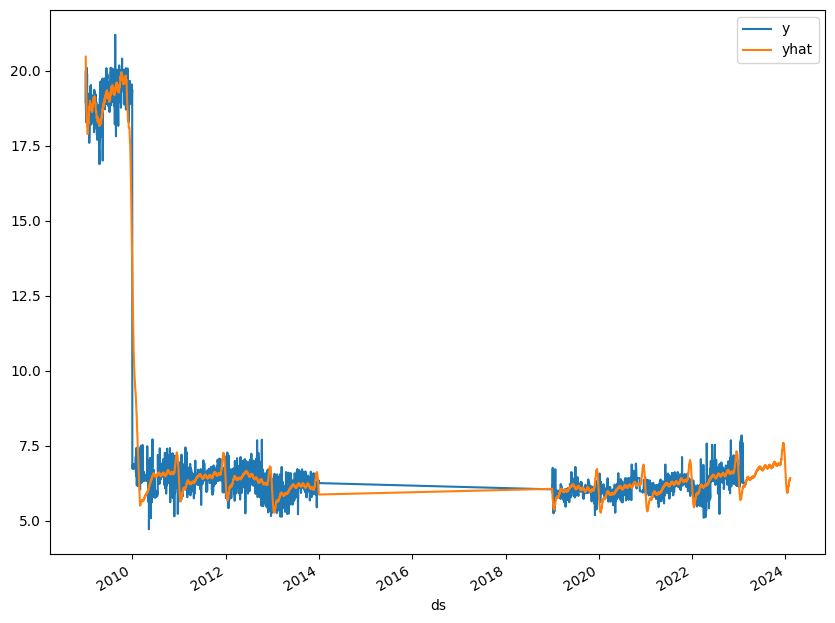

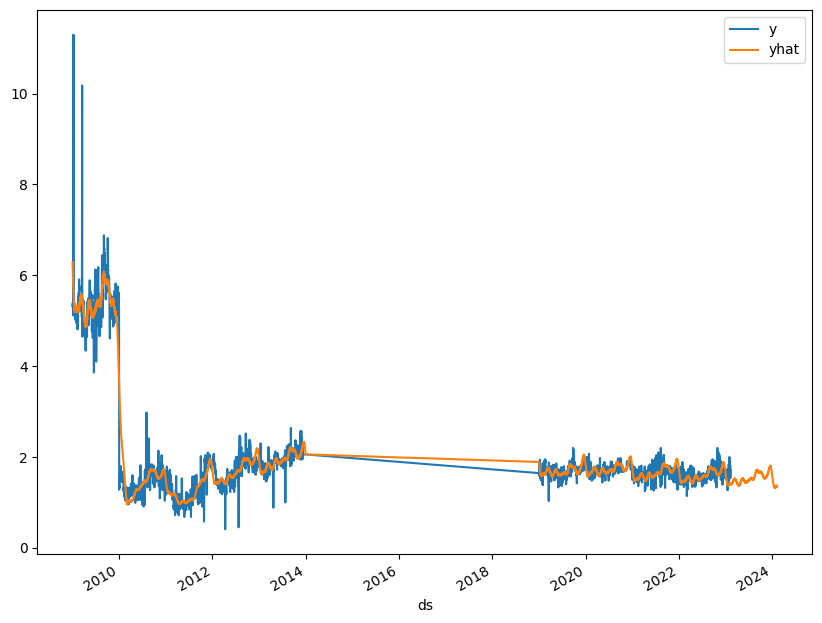

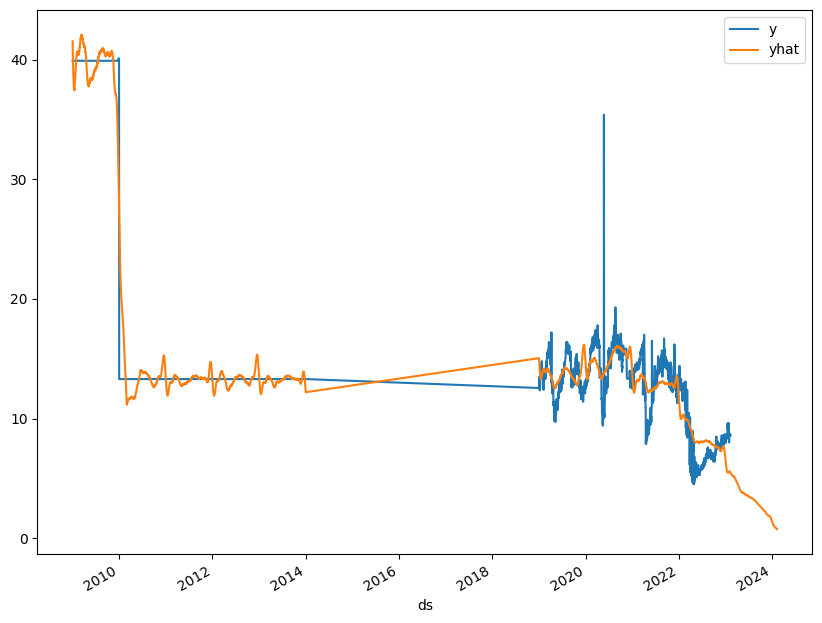

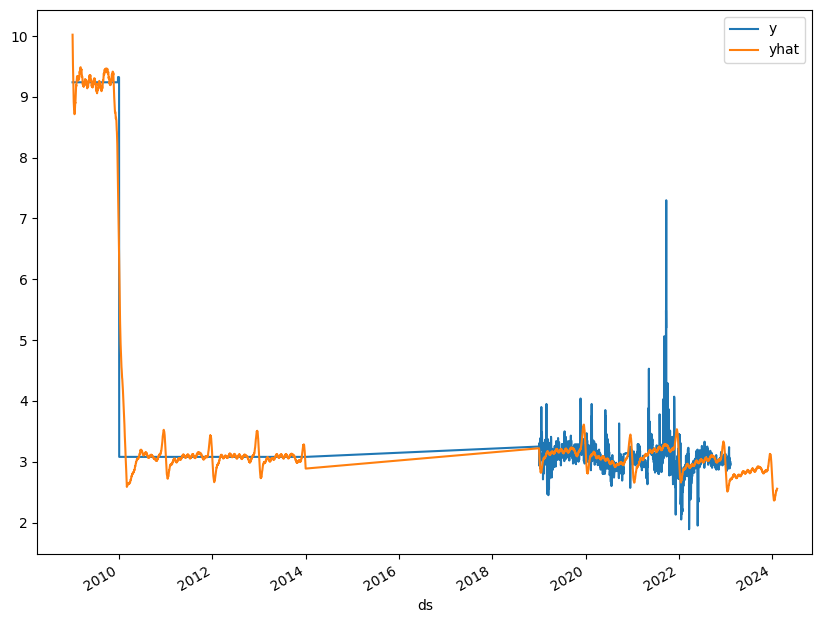

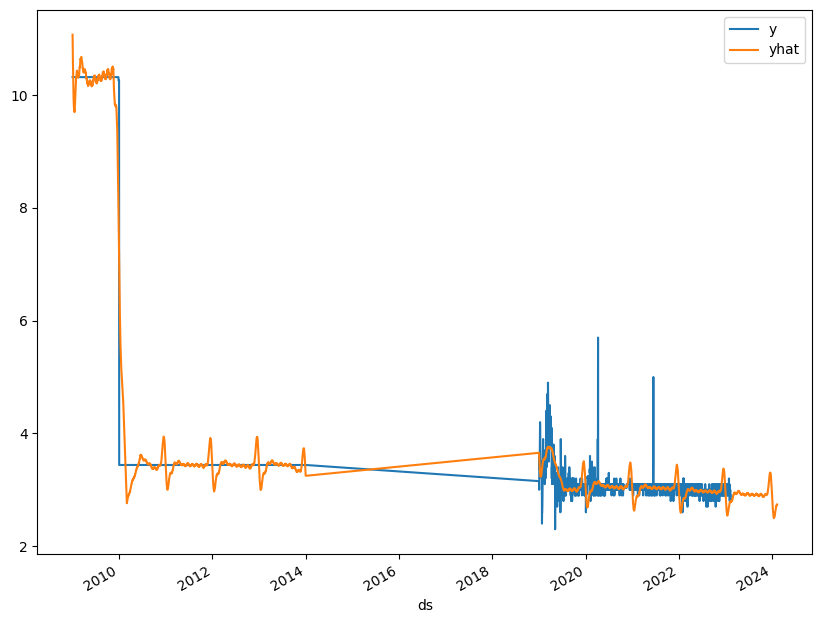

In [ ]:
#Converting to Pandas For Visualization 
pd_df = pyspark_df.toPandas()
pd_df=pd_df.set_index('ds')

#Visualizing the prediction done by the model
for i in range(1,6):
  st="category_code=="+str(i)
  pd_df.query(st)[['y','yhat']].plot()

### ***Evaluation Metrics***

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import abs

preds_non_null = pyspark_df.dropna(subset=["y", "yhat"])

evaluator = RegressionEvaluator(labelCol="y", predictionCol="yhat", metricName="rmse")
rmse = evaluator.evaluate(preds_non_null)
print("RMSE:", rmse)

# Calculate the absolute percentage error using PySpark functions
abs_percentage_error = abs((preds_non_null["y"] - preds_non_null["yhat"]) / preds_non_null["y"])

# Calculate the mean absolute percentage error using PySpark functions
mape = preds_non_null.select(mean(abs_percentage_error)).collect()[0][0] * 100

# Print the result
print("MAPE: ", mape)

RMSE: 2.3090254787521842
MAPE:  6.297067567199416


In [ ]:

preds_non_null = additive_timeseries_preds.dropna(subset=["y", "yhat"])

evaluator = RegressionEvaluator(labelCol="y", predictionCol="yhat", metricName="rmse")
rmse = evaluator.evaluate(preds_non_null)
print("RMSE:", rmse)

# Calculate the absolute percentage error using PySpark functions
abs_percentage_error = abs((preds_non_null["y"] - preds_non_null["yhat"]) / preds_non_null["y"])

# Calculate the mean absolute percentage error using PySpark functions
mape = preds_non_null.select(mean(abs_percentage_error)).collect()[0][0] * 100

# Print the result
print("MAPE: ", mape)

RMSE: 2.950538677764245
MAPE:  7.390671068622377


### ***Random Forest Regressor***

Mean Squared Error for column pH_Raw: 0.22513685766267835
Root Mean Squared Error for column pH_Raw: 0.474485887738169
Mean Absolute Error for column pH_Raw: 0.38535801640213646
R-squared for column pH_Raw: 0.22438043280786524
Standard Deviation of Real Values for column pH_Raw: 0.392200240969675
Standard Deviation of Predicted Values for column pH_Raw: 0.2232105639312795


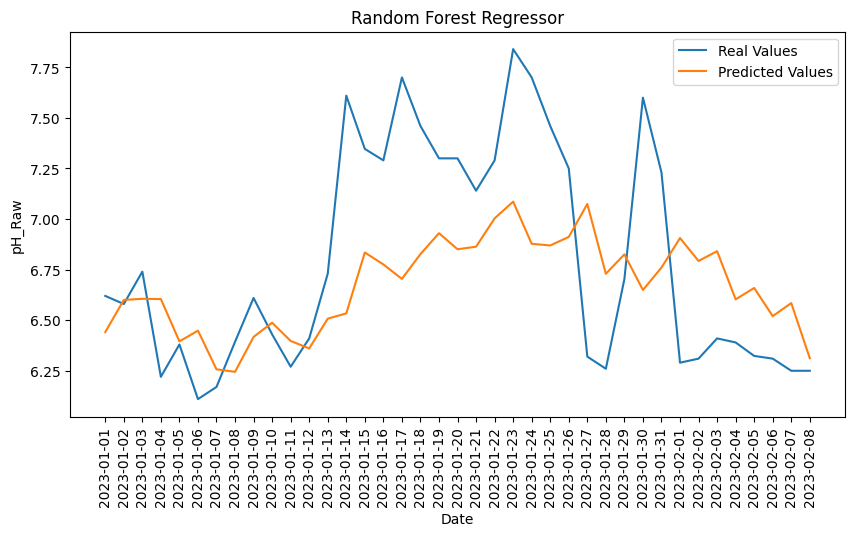

Mean Squared Error for column Chlorine_Free: 0.02725471136668859
Root Mean Squared Error for column Chlorine_Free: 0.1650900098936595
Mean Absolute Error for column Chlorine_Free: 0.12443992921991445
R-squared for column Chlorine_Free: -0.003665440405222098
Standard Deviation of Real Values for column Chlorine_Free: 0.3114237274984994
Standard Deviation of Predicted Values for column Chlorine_Free: 0.09757963499317605


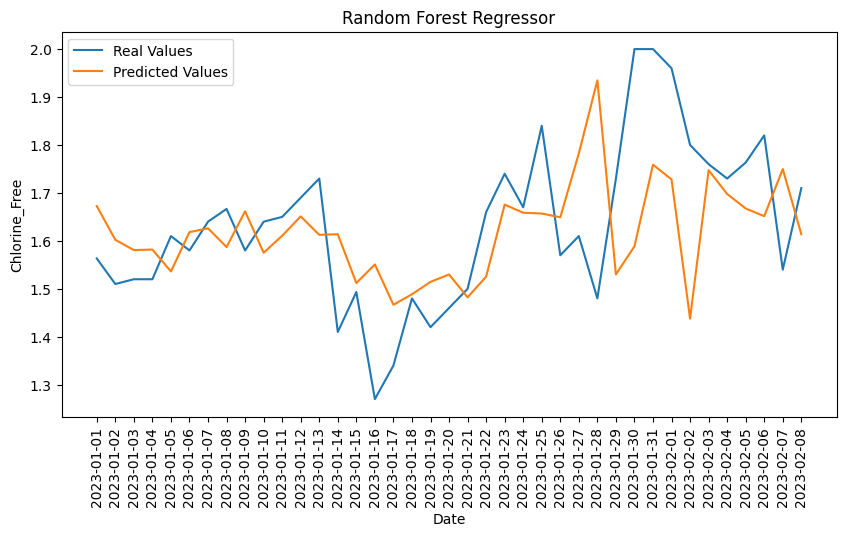

Mean Squared Error for column Total_Dissolved_Solids_Raw: 1.0565121252421676
Root Mean Squared Error for column Total_Dissolved_Solids_Raw: 1.0278677566896277
Mean Absolute Error for column Total_Dissolved_Solids_Raw: 0.7193692307692316
R-squared for column Total_Dissolved_Solids_Raw: -3.7622573141340663
Standard Deviation of Real Values for column Total_Dissolved_Solids_Raw: 1.1260962168215698
Standard Deviation of Predicted Values for column Total_Dissolved_Solids_Raw: 0.6833327252607106


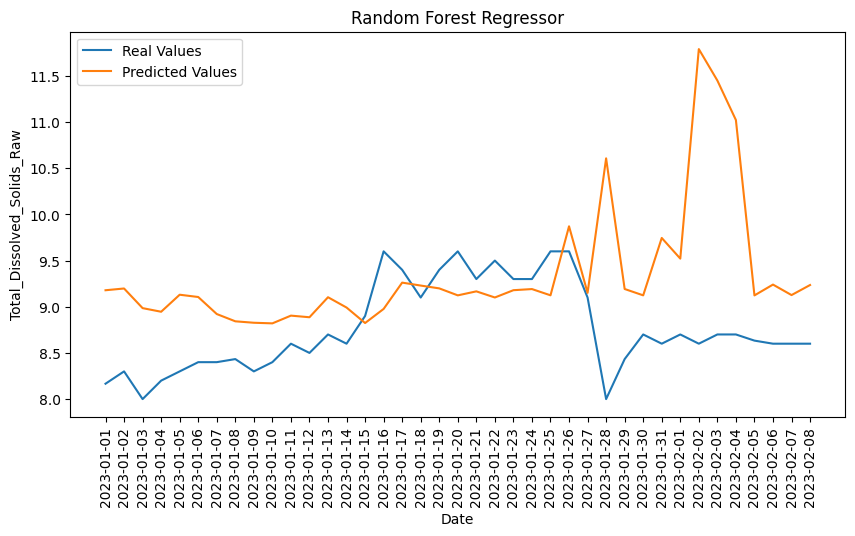

Mean Squared Error for column Hardness_Raw: 0.06517490712820527
Root Mean Squared Error for column Hardness_Raw: 0.2552937663324455
Mean Absolute Error for column Hardness_Raw: 0.22035435897435926
R-squared for column Hardness_Raw: -8.381010578013008
Standard Deviation of Real Values for column Hardness_Raw: 0.17884827299352313
Standard Deviation of Predicted Values for column Hardness_Raw: 0.1156273452298009


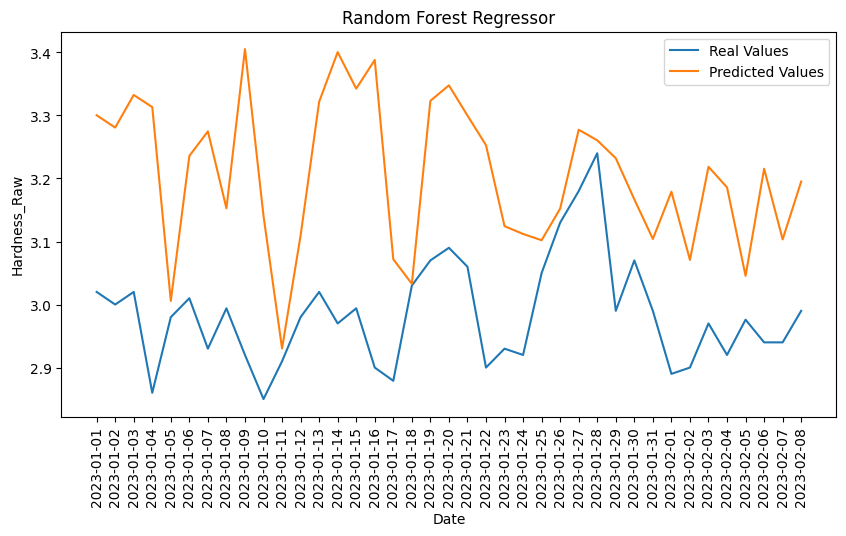

Mean Squared Error for column Alkalinity_Raw: 0.01349899555555559
Root Mean Squared Error for column Alkalinity_Raw: 0.11618517786514591
Mean Absolute Error for column Alkalinity_Raw: 0.09183589743589754
R-squared for column Alkalinity_Raw: -0.6940571155115529
Standard Deviation of Real Values for column Alkalinity_Raw: 0.21339318301374519
Standard Deviation of Predicted Values for column Alkalinity_Raw: 0.03636607961628376


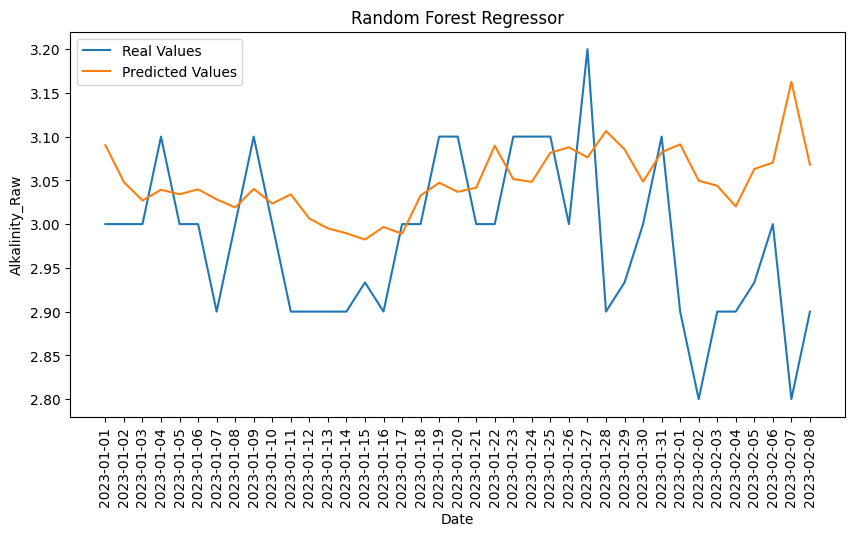

Mean Squared Error for column UVT_Raw: 11.364185753390288
Root Mean Squared Error for column UVT_Raw: 3.371080799000565
Mean Absolute Error for column UVT_Raw: 2.7246324786324743
R-squared for column UVT_Raw: -0.4247360728804137
Standard Deviation of Real Values for column UVT_Raw: 4.783716379593719
Standard Deviation of Predicted Values for column UVT_Raw: 2.67973763387566


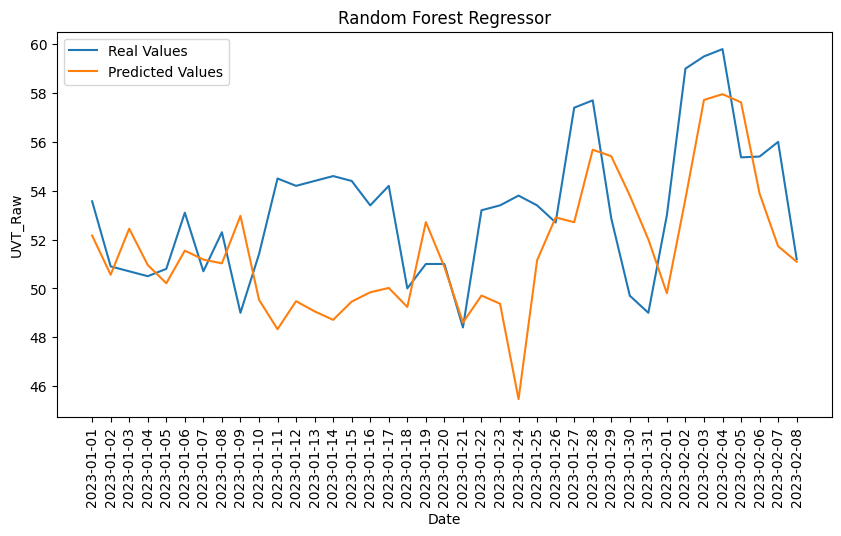

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import numpy as np

cols= final_df.columns[1:]
df = final_df

# convert date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# convert date column to yyyy-mm-dd format
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

# Set 'Date' column as index
df.set_index('Date', inplace=True)

for c in cols:
  
  # Create lagged features
  for i in range(1, 13):
    s = c+'_lag'+str(i)
    df[s] = df[c].shift(i)

  # Drop rows with missing values
  df.dropna(inplace=True)

  # Split into train and test sets
  train = df.loc[:'2021-12-31']
  test = df.loc['2023-01-01':]

  # Separate features and target variable
  X_train = train.drop(c, axis=1)
  y_train = train[c]
  X_test = test.drop(c, axis=1)
  y_test = test[c]

  # Train Random Forest Regressor
  rf = RandomForestRegressor(n_estimators=100, random_state=42)
  rf.fit(X_train, y_train)

  # Make predictions on test set
  y_pred = rf.predict(X_test)

  # Evaluate performance with mean squared error and other metrics
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = np.mean(np.abs(y_test - y_pred))
  r2 = rf.score(X_test, y_test)
  std = np.std(y_pred)
  std1 = np.std(y_train)
  # Print evaluation metrics
  print(f'Mean Squared Error for column {c}:', mse)
  print(f'Root Mean Squared Error for column {c}:', rmse)
  print(f'Mean Absolute Error for column {c}:', mae)
  print(f'R-squared for column {c}:', r2)
  print(f'Standard Deviation of Real Values for column {c}:', std1)
  print(f'Standard Deviation of Predicted Values for column {c}:', std)

  # Plot predicted and real values
  plt.figure(figsize=(10,5))
  plt.plot(y_test.index, y_test.values, label='Real Values')
  plt.plot(y_test.index, y_pred, label='Predicted Values')
  plt.xlabel('Date')
  plt.ylabel(c)
  plt.legend()
  plt.xticks(rotation=90)
  plt.title('Random Forest Regressor')
  plt.show()

